# Лабораторная работа №1
Выполнил студент гр. САПР-1.4: Дешевов П.П.
### Цель и задачи: 
- Познакомиться с понятием «большие данные» и способами их обработки;
- Познакомиться с инструментом Apache Spark и возможностями, которые он предоставляет для обработки больших данных.
- Получить навыки выполнения разведочного анализа данных использованием pyspark.

Инициализируем необходимые для работы библиотеки

In [1]:
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct, when
from pyspark.sql.types import *

Инициализируем сессию PySpark и загружаем data set

In [3]:
MAX_MEMORY = '1G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/financial_fraud_detection.csv'
# Load the main data set into pyspark data frame 
df = spark.read \
        .option("header", True) \
        .option("inferSchema", 'True') \
        .option("delimiter", ",") \
        .csv(filename_data, mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))
df = df.withColumn("isFraud", df.isFraud.cast("boolean"))
df = df.withColumn("isFlaggedFraud", df.isFlaggedFraud.cast("boolean"))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


Анализ типов признаков в data set

In [4]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: boolean (nullable = true)
 |-- isFlaggedFraud: boolean (nullable = true)

Columns overview


,Column Name,Data type
0,step,int
1,type,string
2,amount,double
3,nameOrig,string
4,oldbalanceOrg,double
5,newbalanceOrig,double
6,nameDest,string
7,oldbalanceDest,double
8,newbalanceDest,double
9,isFraud,boolean


В дата сете нету пропущенных значений

Так как работа ведется на дата сете финансовых операций, то его отчистка от выбросов является некорректной

Статистические показатели признаков

In [5]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

Data frame describe (string and numeric columns only):


,summary,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,count,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620,6362620
1,mean,243.39724563151657,None,179861.9035491322,None,833883.1040744863,855113.6685785893,None,1100701.6665196433,1224996.3982019275
2,stddev,142.33197104913054,None,603858.2314629358,None,2888242.673037555,2924048.502954259,None,3399180.1129944846,3674128.942119643
3,min,1,CASH_IN,0.0,C1000000639,0.0,0.0,C1000004082,0.0,0.0
4,max,743,TRANSFER,9.244551664E7,C999999784,5.958504037E7,4.958504037E7,M999999784,3.5601588935E8,3.5617927892E8


Визуализация распределения наиболее важных признаков

Fraud operations count =  8213
Legal operations count =  6354407


([<matplotlib.patches.Wedge at 0x7f9338eb83d0>,
 [Text(1.0999909553139726, 0.004460742926250505, 'fraud'),
  Text(-1.0999909550023677, -0.004460819765390592, 'legal')])

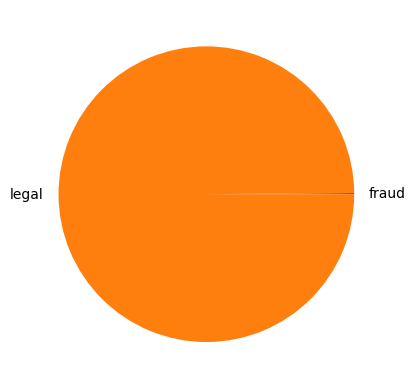

In [6]:
# find fraud operations df
fraud_df = df.filter(df.isFraud == True)
print("Fraud operations count = ", fraud_df.count())

# find not fraud operation df
legal_df = df.filter(df.isFraud == False)
print("Legal operations count = ", legal_df.count())

fig, axs = plt.subplots()
axs.pie(x=[fraud_df.count(), legal_df.count()], labels=["fraud", "legal"])

Из диаграммы видно, что большая часть финансовых операций явялются легальными

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'All amounts hist')

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Fraud amounts hist')

<BarContainer object of 50 artists>

Text(0.5, 1.0, 'Legal amount hist')

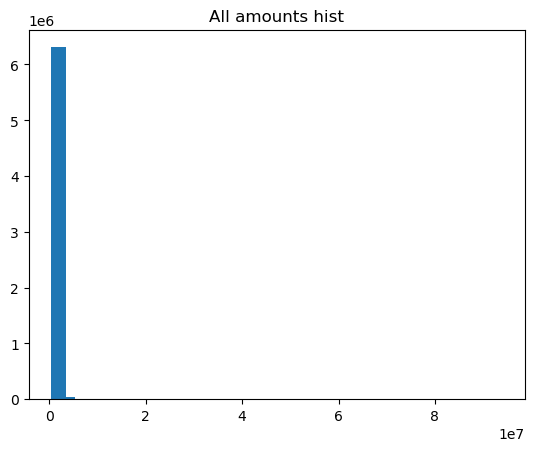

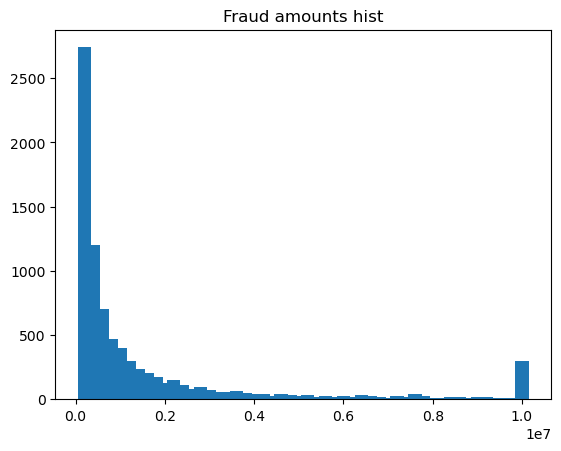

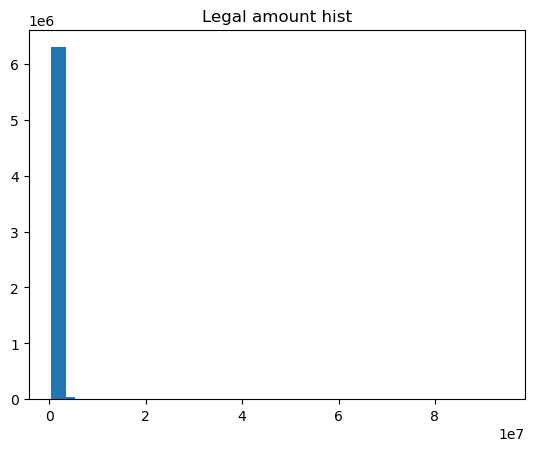

In [7]:
all_bins, all_counts = df.select('amount').rdd.flatMap(lambda x: x).histogram(50)
fraud_bins, fraud_counts = fraud_df.select('amount').rdd.flatMap(lambda x: x).histogram(50)
legal_bins, legal_counts = legal_df.select('amount').rdd.flatMap(lambda x: x).histogram(50)

f1, a1 = plt.subplots()
a1.bar(x=all_bins[1:len(all_bins)], height=all_counts, width=3000000, label='all amount')
a1.set_title("All amounts hist")

f2, a2 = plt.subplots()
a2.bar(x=fraud_bins[1:len(fraud_bins)], height=fraud_counts, width=300000, label='fraud amount')
a2.set_title("Fraud amounts hist")

f3, a3 = plt.subplots()
a3.bar(x=legal_bins[1:len(legal_bins)], height=legal_counts, width=3000000, label='legal amount')
a3.set_title("Legal amount hist")

Из вышепреденных выше гистрограм следует, что большая часть финансовых операций - операции с малым объемом средств. Причем, это не зависит от того является ли операция легальной или нелегальной 


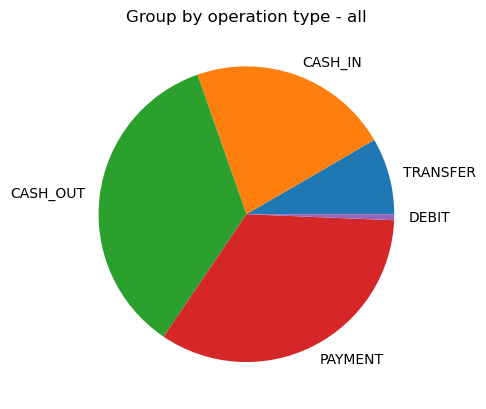

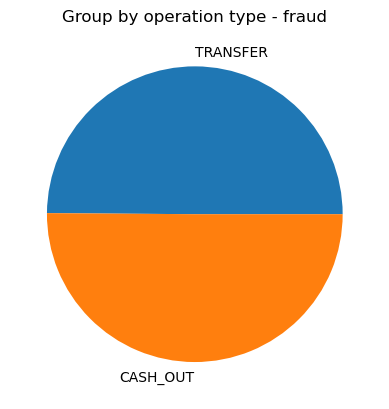

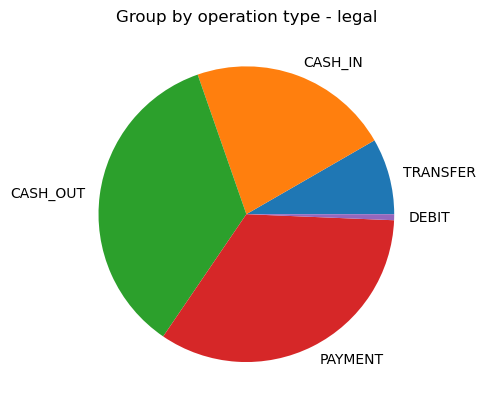

In [8]:
def separateByOperations(df, pie_title):
    operation_df = df.select(df.type).groupBy('type').count()
    operation_types = operation_df.select('type').toPandas()['type']
    operation_count = operation_df.select('count').toPandas()['count']
    fig, ax = plt.subplots()
    ax.pie(x=operation_count, labels=operation_types)
    ax.set_title(pie_title)


separateByOperations(df, 'Group by operation type - all')
separateByOperations(fraud_df, 'Group by operation type - fraud')
separateByOperations(legal_df, 'Group by operation type - legal')


Из выше представленных диаграмм следует, что незаконные финансовые операции относятся только к двум типам: ‘CASH_OUT’ – снятие, ‘TRANSFER’ – перевод

Проведем расчет корреляций между признаками

In [10]:
def createCorrMatrix(df, column_names):
    matrix_df = pd.DataFrame()
    matrix_df['name'] = column_names
    for first in column_names:
        column = []
        for second in column_names:
            corr = df.stat.corr(first, second)
            column.append(corr)
        matrix_df[first] = column
    return matrix_df

column_names = list(map(lambda x: x[0], df.dtypes))

types = df.groupBy('type').count().toPandas()['type'].tolist()
for i_type in range(len(types)):
    df = df.withColumn('type', when(df.type == types[i_type], i_type).otherwise(df.type))
df = df.withColumn('type', df.type.cast('int'))
df = df.withColumn('isFraud', df.isFraud.cast('int'))
df = df.withColumn('isFlaggedFraud', df.isFlaggedFraud.cast('int'))
for delete_column_names in ['nameOrig', 'nameDest']:
    column_names.remove(delete_column_names)
createCorrMatrix(df, column_names)

,name,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,step,1.000000,-0.000856,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
1,type,-0.000856,1.000000,0.230703,0.297586,0.306623,0.232709,0.237922,0.025433,0.001767
2,amount,0.022373,0.230703,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
3,oldbalanceOrg,-0.010058,0.297586,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
4,newbalanceOrig,-0.010299,0.306623,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
5,oldbalanceDest,0.027665,0.232709,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
6,newbalanceDest,0.025888,0.237922,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
7,isFraud,0.031578,0.025433,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
8,isFlaggedFraud,0.003277,0.001767,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


### Выводы:
- В ходе работы был проведен анализ выбранного дата сета - https://www.kaggle.com/datasets/ealaxi/paysim1
- Рассчитаны основные статистические показатели признаков
- Визуализированы распределения наиболее важных признаков
- Расчитаны корреляций между признаками
- Все незаконные операции относятся к двум типам: CASH_OUT и TRANSFER